Trabajo presentado por: Juliana Andrea Amézquita Abello

# Prediciendo el precio de venta de los inmuebles para vivienda en Bogotá, Colombia

Datos provistos por <a href='https://www.properati.com.co/data'>Properati</a>





# Contexto

Para esta actividad se utilizaron los datos de la plataforma de anuncios inmobiliarios de Properati Colombia. Dicho dataset contiene los anuncios de diferentes predios que se ofrecen tanto para la renta como para la venta. En terminos generales, incluye varios tipos de propiedades (casa, apartamentos, oficinas, locales, etc.) que se ofrecen en las diferentes ciudades y municipios del país. Además, para cada inmueble el dataset contiene información sobre las características del predio como el área, cantidad de habitaciones, baños, precio, ubicación, entre otros. 

Dicho dataset, ha sido filtrado y modificado a efectos de simplicar y cumplir con el objetivo propuesto en la actividad. Si se desea conocer el proceso de filtrado y limpieza efectuado sobre el dataset original puede revisar el notebook adjunto en este repositorio de <a href='https://github.com/juli-amezquita/Precios-vivienda-Bogota/blob/main/limpieza_dataset.ipynb'>GitHub,</a> de lo contrario puede continuar leyendo este notebook en el que se presentan los análisis y resultados sobre el objetivo planteado.

# Objetivo de la actividad

Predecir el precio de venta de los inmuebles exclusivamente para vivienda en Bogotá (apartamentos y casas). Para esto se utilizará un algoritmo de ensemble learning y un modelo de redes neuronales. Al final compararemos su performance.

In [ ]:
# Se importan las librerias a utilizar
%tensorflow_version 2.x
import tensorflow as tf

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

2.7.0


# Análisis Exploratorio de Datos



## Carga de Datos

In [ ]:
# Carga de datos

url = 'https://github.com/juli-amezquita/Precios-vivienda-Bogota/blob/main/properties_bog.csv?raw=true'

# Se crea un dataframe con los datos
data = pd.read_csv(url, sep = ';')
data.head()

,Unnamed: 0,lat,lon,ciudad,zona,localidad,barrio,habitaciones,baños,area,area_privada,precio,moneda,tipo_propiedad,tipo_operacion
0,0,4.703,-74.057,Bogotá D.C,Zona Noroccidental,Suba,El Batán,5.0,3.0,175.0,253.0,8.000000e+08,COP,Casa,Venta
1,1,4.724,-74.024,Bogotá D.C,Zona Norte,Usaquén,Bosque De Pinos,3.0,4.0,550.0,369.0,1.800000e+09,COP,Casa,Venta
2,2,4.728,-74.046,Bogotá D.C,Zona Norte,Usaquén,Cedritos,2.0,1.0,50.0,50.0,2.400000e+08,COP,Apartamento,Venta
3,3,4.634,-74.064,Bogotá D.C,Zona Chapinero,Chapinero,Chapinero Central,1.0,1.0,31.0,31.0,1.800000e+08,COP,Apartamento,Venta
4,4,4.727,-74.036,Bogotá D.C,Zona Norte,Usaquén,Cedritos,1.0,2.0,74.0,74.0,5.500000e+08,COP,Apartamento,Venta


In [ ]:
# Exploramos la estructura de nuestros datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1802 non-null   int64  
 1   lat             1802 non-null   float64
 2   lon             1802 non-null   float64
 3   ciudad          1802 non-null   object 
 4   zona            1802 non-null   object 
 5   localidad       1802 non-null   object 
 6   barrio          1802 non-null   object 
 7   habitaciones    1802 non-null   float64
 8   baños           1802 non-null   float64
 9   area            1802 non-null   float64
 10  area_privada    1802 non-null   float64
 11  precio          1802 non-null   float64
 12  moneda          1802 non-null   object 
 13  tipo_propiedad  1802 non-null   object 
 14  tipo_operacion  1802 non-null   object 
dtypes: float64(7), int64(1), object(7)
memory usage: 211.3+ KB


## Caracterización de las variables

Como se observa el dataset contiene 1802 filas u observaciones y 15 columnas las cuales procedemos a caracterizar: 

* lat: identifica la latitud, es una variable continua
* lon: identifica la longitud, es una variable continua
* ciudad: variable categórica de una sola clase (Bogotá D.C)
* zona: variable categórica nominal de múltiples clases
* localidad: variable categórica nominal de múltiples clases
* barrio: variable categórica nominal de múltiples clases
* habitaciones: variable numérica discreta de valores múltiples
* baños: variable numérica discreta de valores múltiples
* area: representa el área total del inmueble. Es una variable continua (se especifica en m2)
* area_privada: representa el área construida del inmueble. Es una variable continua (se especifica en m2)
* precio: variable continua (variable a predecir)
* moneda: variable categórica de una sola clase (COP: peso Colombiano)
* tipo_propiedad: variable categórica nominal de dos clases (Apartamento y Casa)
* tipo_operacion: variable categórica de una sola clase (Venta)

Nuestra variable a predecir será el precio y el resto de variables excepto por ciudad, moneda y tipo_operación serán las variables predictoras. Quedamos con 10 atributos de entrada (variables predictoras).




In [ ]:
# Se elimina la columna Unnamed, ya que es el mismo índice del dataframe y las variables tipo_operacion, moneda y ciudad pues todos las observaciones son de la misma ciudad, están a la venta y su moneda es COP
data = data.drop(columns = ['Unnamed: 0', 'moneda', 'ciudad', 'tipo_operacion'])
data.head(3)

,lat,lon,zona,localidad,barrio,habitaciones,baños,area,area_privada,precio,tipo_propiedad
0,4.703,-74.057,Zona Noroccidental,Suba,El Batán,5.0,3.0,175.0,253.0,8.000000e+08,Casa
1,4.724,-74.024,Zona Norte,Usaquén,Bosque De Pinos,3.0,4.0,550.0,369.0,1.800000e+09,Casa
2,4.728,-74.046,Zona Norte,Usaquén,Cedritos,2.0,1.0,50.0,50.0,2.400000e+08,Apartamento


## Valores faltantes

In [ ]:
print("Total Valores Faltantes por Columna")
print(data.isna().sum())

Total Valores Faltantes por Columna
lat               0
lon               0
zona              0
localidad         0
barrio            0
habitaciones      0
baños             0
area              0
area_privada      0
precio            0
tipo_propiedad    0
dtype: int64


## Distribución Variables Numéricas

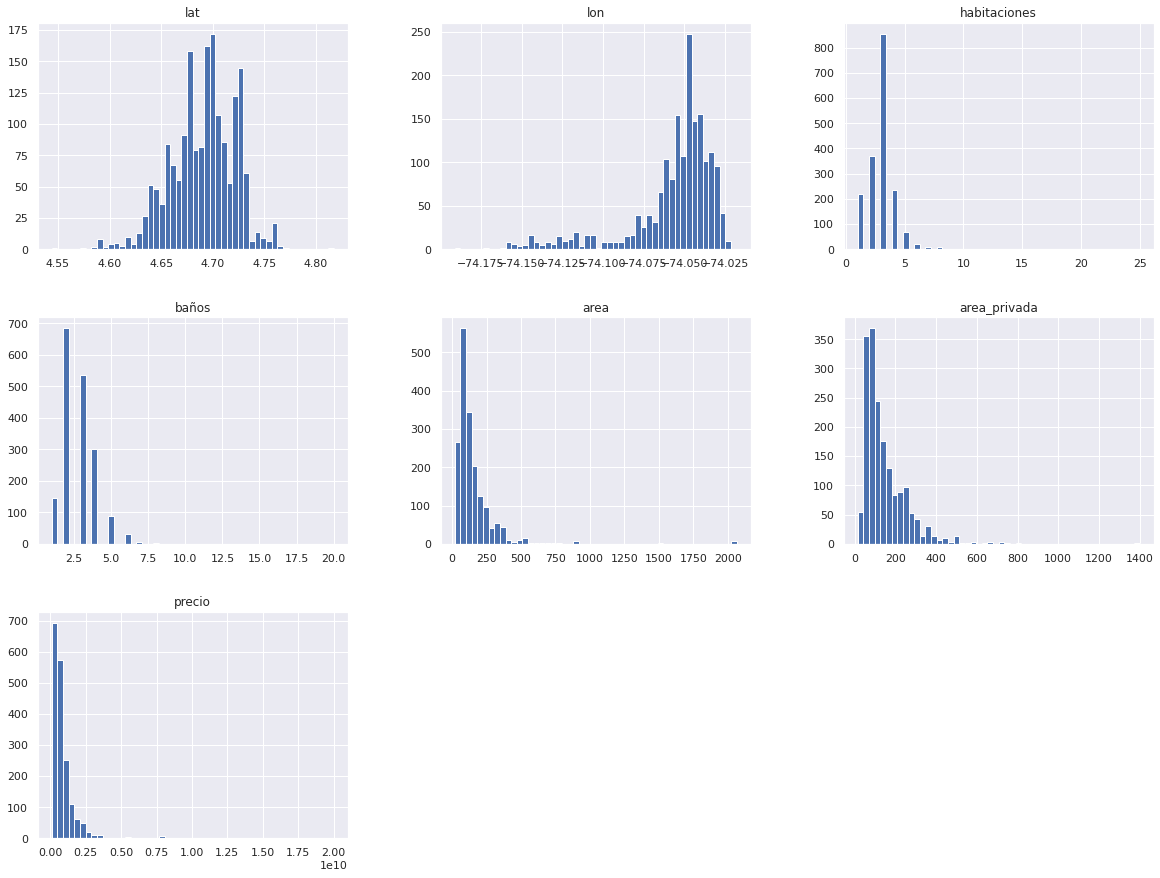

In [ ]:
data.hist(bins=50, figsize=(20,15))
plt.show()

Este gráfico nos muestra que todas las variables tienen una distribución sesgada la mayoría hacía la izquierda. Llama la atención la variable objetivo, que concentra la mayoría de los precios hacía los valores más bajos. Igualmente, vemos en la variable habitaciones que lo más común es que la mayoría de los inmuebles tengan 3 habitaciones. Asímismo, la variable baños concentra la mayoría de muestras en 2. Respecto a la variable área vemos que la mayoría de inmuebles se concentran alrededor de los 100 metros cuadrados y se observan algunos valores atípicos de alrededor de 900 y 2000 metros cuadrados.

## Distribución Variables Categóricas

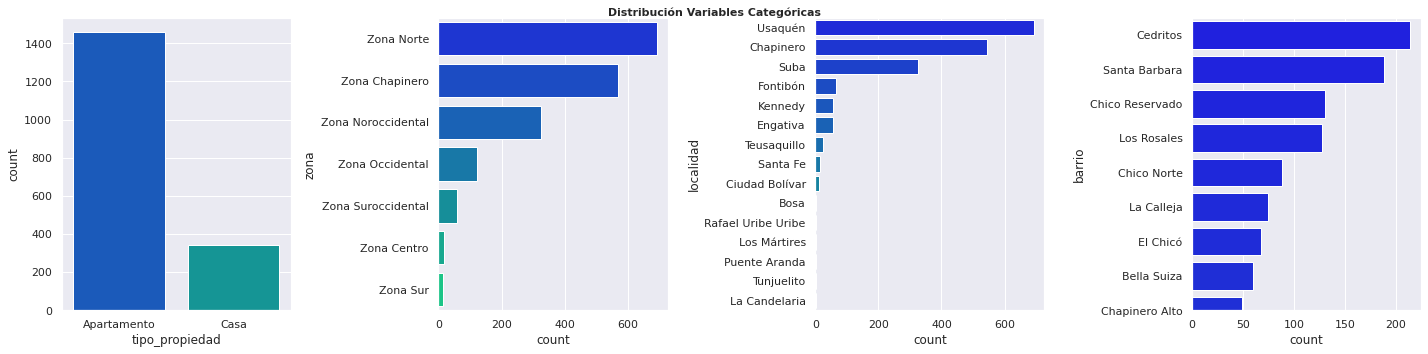

In [ ]:
# Gráfico de distribución para cada variable categórica

sns.set()
fig, ax= plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

sns.countplot(ax=ax[0], data = data, x= "tipo_propiedad", order = data["tipo_propiedad"].value_counts().index, 
              palette="winter")

sns.countplot(ax=ax[1], data = data, y= "zona", order = data["zona"].value_counts().index, palette="winter")

sns.countplot(ax=ax[2], data = data, y= "localidad", order = data["localidad"].value_counts().index, palette="winter")

sns.countplot(ax=ax[3], data = data, y= "barrio", order = data["barrio"].value_counts().index, palette="winter")

plt.ylim(8)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle('Distribución Variables Categóricas', fontsize = 11, fontweight = "bold")
plt.show()

Este gráfico muestra la distribución de todas las variables categóricas de interés en la base de datos. Vemos que la mayoría de inmuebles publicados en esta plataforma son de tipo apartamento, acumulando más de 1400 inmueblesy las casas son minoría. 

Hay una variable zona que indica la ubicación de los inmuebles publicados en la ciudad. La mayoría están representados en la zona note de la ciudad y la minoría en la zona sur. Así mismo, vemos que todos los inmuebles están distribuidos en 7 zonas. 

La variable localidad contempla 15 categorías, sin embargo, solo hay representación en 9 de ellas. La mayoría de inmuebles se encuentran en la localidad de Usaquen. 

Finalmente, la variable barrio tiene 100 categorías, pero por comodidad en este gráfico solo se han mostrado los 9 barrios que tienen mayor representación de inmuebles anunciados en la página de Properati. La mayoría de inmuebles publicados se encuentran en el barrio Cedritos.

## Distribución conjunta 



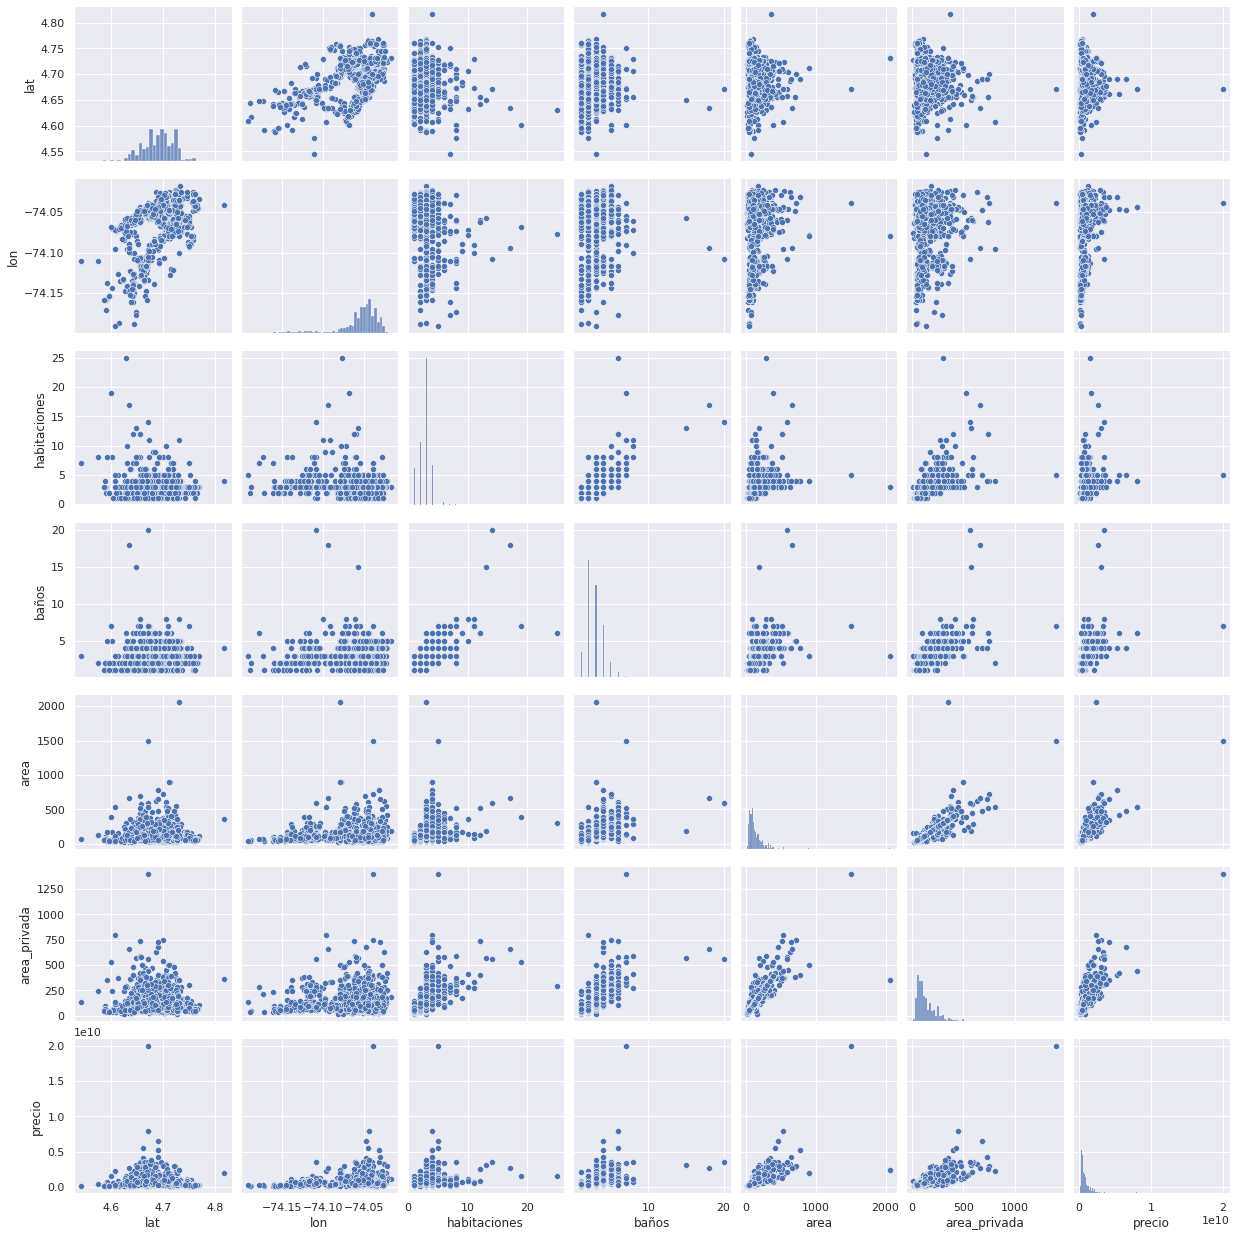

In [ ]:
sns.pairplot(data, diag_kind="hist", height=2.5)

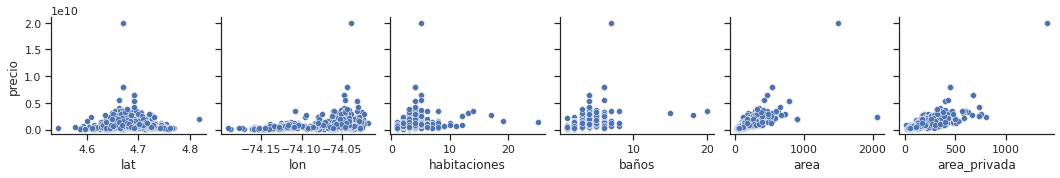

In [ ]:
# Tomamos un fragmento del pairplot para visualizar mejor la relación del precio respecto a algunas viariables
sns.set(style="ticks")
sns.pairplot(data,
             x_vars=["lat", "lon", "habitaciones", "baños", "area", "area_privada"],
             y_vars=["precio"], palette="viridis")

Tomamos un fragmento del pairplot para revisar cómo es la relación de las variables predictoras y nuestra variable objetivo (precio). Se observa que las cuatro variables numèricas de nuestro dataset tienen una relación positiva con el precio. Esta relación se ve más marcada en las variables que contemplan las áreas de los inmuebles, más específicamente en la variable área total, lo que es de esperarse. En cuanto a las variables baños y habitaciones se observa una relación positiva pero con una pendiente menos inclinada, lo que indica que a pesar de que los bañoos o las habitaciones aumenten, el precio no necesariamente aumenta, solo lo hace hasta cierto punto. En todas las variables es evidente la presencia de algunos datos atípicos.

# ¿Cómo están distribuidos los inmuebles de vivienda para la venta en Bogotá?

Con la longitud y la latitud podemos ver como se distribuyen los inmuebles en la ciudad de acuerdo al tipo de propiedad. Se confirma lo que ya habíamos visto en los análisis anteriores: la mayoría de anuncios son de inmuebles de tipo apartamento y se encuentran ubicados hacia el norte de la ciudad.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


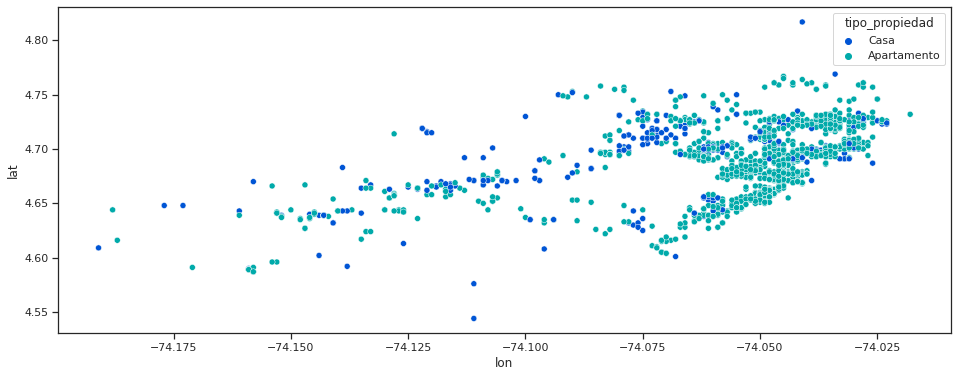

In [ ]:
plt.figure(figsize = (16,6))
fig = sns.scatterplot(data.lon,data.lat, hue = data['tipo_propiedad'], legend = True, palette = 'winter')

## Algunas estadísticas

En la siguiente tabla podemos ver informaciones que nos interesan como la media y las desviaciones. También se puede observar lo diferente que son los ragos de cada variable, lo que nos permite concluir que antes de entrenar nuestros modelos es necesario escalar esos rangos.

In [ ]:
data = data.drop(columns = [ 'lat', 'lon'])
stats = data.describe().transpose()
stats

,count,mean,std,min,25%,50%,75%,max
habitaciones,1802.0,2.923418e+00,1.502068e+00,1.0,2.0,3.0,3.000000e+00,2.500000e+01
baños,1802.0,2.825749e+00,1.290052e+00,1.0,2.0,3.0,3.000000e+00,2.000000e+01
area,1802.0,1.543990e+02,1.737423e+02,20.0,74.0,107.0,1.750000e+02,2.064000e+03
area_privada,1802.0,1.460477e+02,1.075243e+02,15.0,74.0,110.0,1.890000e+02,1.400000e+03
precio,1802.0,8.675910e+08,9.455027e+08,109000000.0,398000000.0,600000000.0,1.000000e+09,2.000000e+10


# Preprocesamiento de datos




## Transformación variables predictoras

Las transformaciones a realizar son las siguientes: 

* Aplicar OneHotEncoder a todas las variables categóricas
* Escalar los datos utilizando MinMaxScaler, para mantenerlos en un rango de 0 a 1. Se utliza este método principalmente porque MinMaxScaler permite conservar la distribución original de los datos y no reduce la importancia de los valores atípicos.

Para realizar esto vamos a utilizar la clase ColumnTransformer, este estimador permite que diferentes columnas o subconjuntos de columnas de entrada se transformen por separado. Lo anteior es muy útil pues permite combinar varios mecanismos de transformación en un solo paso.

In [ ]:
# División de atributos (X) y target (y)

X = data.drop(['precio'], axis=1)
y = data.precio

print(X.shape)
print(y.shape)

(1802, 8)
(1802,)


In [ ]:
# Se importan las librerias a utilizar para crear nuestro pipeline de transformación
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_selector

# Se identifican las columnas numéricas y las categóricas
categoricas = X.select_dtypes(include=['object']).columns.to_list()
numericas = X.select_dtypes(include=['float64']).columns.to_list()

transformaciones = ColumnTransformer(transformers=[
                                                   ('paso1', MinMaxScaler(), numericas),
                                                   ('paso2', OneHotEncoder(sparse=False), categoricas)
                                                   ])

In [ ]:
# Se aplica las transformaciones
X_transformadas = transformaciones.fit_transform(X)

In [ ]:
# Se obtiene una matriz numpy de 1802 filas con 130 columnas
X_transformadas.shape

(1802, 128)

In [ ]:
# Convertir el output de las transformaciones en un dataframe que nos permita identificar el nombre de las nuevas columnas

cat_names = transformaciones.named_transformers_['paso2'].get_feature_names_out(categoricas)
labels = np.concatenate([numericas, cat_names])
X_prep = transformaciones.fit_transform(X)
X_prep = pd.DataFrame(X_prep, columns=labels)
X_prep.head()

,habitaciones,baños,area,area_privada,zona_Zona Centro,zona_Zona Chapinero,zona_Zona Noroccidental,zona_Zona Norte,zona_Zona Occidental,zona_Zona Sur,zona_Zona Suroccidental,localidad_Bosa,localidad_Chapinero,localidad_Ciudad Bolívar,localidad_Engativa,localidad_Fontibón,localidad_Kennedy,localidad_La Candelaria,localidad_Los Mártires,localidad_Puente Aranda,localidad_Rafael Uribe Uribe,localidad_Santa Fe,localidad_Suba,localidad_Teusaquillo,localidad_Tunjuelito,localidad_Usaquén,barrio_Alhambra,barrio_Barrancas,barrio_Bella Suiza,barrio_Bellavista Occidental,barrio_Bosa La Paz,barrio_Bosa Piamonte,barrio_Bosa Porvenir,barrio_Bosque De Pinos,barrio_Bosque Popular,barrio_Cantagallo,barrio_Capellania,barrio_Carlos Lleras,barrio_Casablanca,barrio_Castilla,...,barrio_Mirandela,barrio_Modelia,barrio_Nicolas De Federman,barrio_Niza,barrio_Normandia,barrio_Nueva Autopista,barrio_Nueva Zelandia,barrio_Pablo VI,barrio_Palermo,barrio_Parque Central Bavaria,barrio_Pasadena,barrio_Patio Bonito,barrio_Pinar De Suba,barrio_Pontevedra,barrio_Portales Del Norte,barrio_Prado Veraniego,barrio_Puente Largo,barrio_Quinta Camacho,barrio_Quinta Paredes,barrio_Ricaurte,barrio_San Antonio Norte,barrio_San Cipriano,barrio_San Diego,barrio_San Patricio,barrio_Santa Ana,barrio_Santa Barbara,barrio_Santa Maria Del Lago,barrio_Santa Paula,barrio_Santa Teresa,barrio_Sotavento,barrio_Techo,barrio_Turingia,barrio_Usatama,barrio_Venecia,barrio_Villa Alsacia,barrio_Villas De Aranjuez,barrio_Villas De Granada,barrio_Zona Franca,tipo_propiedad_Apartamento,tipo_propiedad_Casa
0,0.166667,0.105263,0.075832,0.171841,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.083333,0.157895,0.259295,0.255596,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.041667,0.000000,0.014677,0.025271,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,0.000000,0.005382,0.011552,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,0.052632,0.026419,0.042599,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Transformación variable objetivo
Primero se hará una transformación Box-Cox a la variable objetivo "precio", para tratar de hacerla más líneal.


In [ ]:
from scipy import stats
demand,fitted_lambda = stats.boxcox(y)
round(fitted_lambda,2)

-0.25

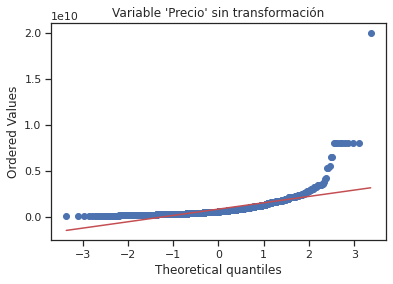

In [ ]:
# Variable precio sin ninguna transformación
stats.probplot(x=(y), dist = "norm", plot = plt)
plt.title("Variable 'Precio' sin transformación")
plt.show()

Dado que lo anterior no tuvo mucho efecto, se prueba con una transformación de raíz cúbica, raíz cuarta y logarítmica para ver si podemos hacerla un poco más lineal.

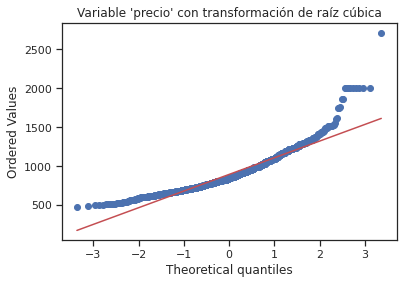

In [ ]:
stats.probplot(x=(y**(1/3)), dist = "norm", plot = plt)
plt.title("Variable 'precio' con transformación de raíz cúbica")
plt.show()

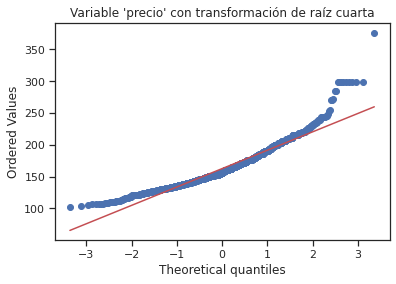

In [ ]:
stats.probplot(x=(y**(1/4)), dist = "norm", plot = plt)
plt.title("Variable 'precio' con transformación de raíz cuarta")
plt.show()

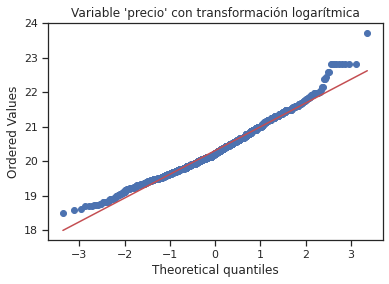

In [ ]:
stats.probplot(x= np.log1p(y), dist = "norm", plot = plt)
plt.title("Variable 'precio' con transformación logarítmica")
plt.show()

Revisando los resultados de las gráficas anteriores podemos ver que la transformación logarítmica es la que mejor nos da una linealidad de la variable objetivo (precio).

In [ ]:
y= np.log1p(y)
y_prep = pd.DataFrame(y)
y_prep.head()

,precio
0,20.500122
1,21.311053
2,19.296149
3,19.008467
4,20.125429


# Separación de los datos train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1441, 128), (361, 128), (1441, 1), (361, 1))

# Modelo Redes Neuronales

In [ ]:
# Librerías a importar 
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

## Definición del modelo

La red neuronal será configurada con 2 capas ocultas densamente conectadas, una capa de entrada y una de salida. Cada una de las capas tiene 15 neuronas, excepto  la capa de salida que fue configurada con 1 neurona puesto que lo que esperamos de salida es un número continuo. Por otro lado, todas las capas excepto la de salida tienen una funciónm de activación "ReLu" para mayor estabilidad.



In [ ]:
def build_model():  
  model = Sequential()
  model.add(Dense(15, activation='relu', input_shape=[len(X_train.keys())]))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(1))
  return model

model = build_model()

# Revisamos la arquitectura de la red
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 15)                1935      
                                                                 
 dense_25 (Dense)            (None, 15)                240       
                                                                 
 dense_26 (Dense)            (None, 15)                240       
                                                                 
 dense_27 (Dense)            (None, 1)                 16        
                                                                 
Total params: 2,431
Trainable params: 2,431
Non-trainable params: 0
_________________________________________________________________


## Compile

* Función de pérdida: Se utiliza MSE que es el error cuadrático medio, la cual es una medida de rendimiento típica en un problema de regresión.
* Optimizador: Se decide utilizar el optmizador RMSprop con un ratio de aprendizaje de 0,001.
* Métricas elegidas:
  * MAPE (Mean Absolute Percentage Error): Calcula el error porcentual absoluto medio entre y_true y y_pred. Mide el tamaño del error (absoluto) en términos porcentuales.
  * RMSE (Root Mean Squared Error): Calcula la distancia media cuadrática mínima entre y_true y y_pred, es decir, cuantifica cuán diferente es el conjunto de valores reales y los predichos por el modelo. Cuanto más pequeño es un valor RMSE, más cercanos son los valores predichos y observados.

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.RootMeanSquaredError()])

## Early Stopping

Una de las razones más comunes del sobreajuste es que la red neuronal realiza más "epochs" de las necesarias. Para evitar el sobreajuste en nuestro modelo, se crea una "parada temprana" automática mediante callbacks, además, se especifican los siguientes parámentros: con el argumento "monitor" se le indica qué métrica debe tener en cuenta y con "patience" se le indica cuántas "epochs" debe considerar para comprobar la mejora.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

## Entrenamiento del modelo

Para entrenar el modelo definimos 1000 "epochs", lo cual significa que los datos pasarán por la red neuronal 1000 veces durante el entrenamiento. Dado que un número muy alto de "epochs" puede generar sobreajuste y a futuro impedir que el modelo generalice bien frente a un conjunto de datos nuevo, en el paso anterior, se creó una parada temprana para ayudar a la red neuronal en no caer en este error. 

Se define un "batch_size" de 100, lo que significa que el modelo está dividiendo los datos en un tamaño de 100 lotes en cada iteración del entrenamiento.

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, batch_size = 100,
                    validation_split = 0.2, verbose=2,
                    callbacks=[early_stop] )

Epoch 1/1000
12/12 - 1s - loss: 409.0200 - mean_absolute_percentage_error: 99.6092 - root_mean_squared_error: 20.2242 - val_loss: 406.2772 - val_mean_absolute_percentage_error: 99.1128 - val_root_mean_squared_error: 20.1563 - 1s/epoch - 93ms/step
Epoch 2/1000
12/12 - 0s - loss: 401.5143 - mean_absolute_percentage_error: 98.6915 - root_mean_squared_error: 20.0378 - val_loss: 397.3628 - val_mean_absolute_percentage_error: 98.0186 - val_root_mean_squared_error: 19.9340 - 73ms/epoch - 6ms/step
Epoch 3/1000
12/12 - 0s - loss: 391.2281 - mean_absolute_percentage_error: 97.4177 - root_mean_squared_error: 19.7795 - val_loss: 385.4218 - val_mean_absolute_percentage_error: 96.5331 - val_root_mean_squared_error: 19.6322 - 70ms/epoch - 6ms/step
Epoch 4/1000
12/12 - 0s - loss: 378.1331 - mean_absolute_percentage_error: 95.7728 - root_mean_squared_error: 19.4456 - val_loss: 370.4187 - val_mean_absolute_percentage_error: 94.6344 - val_root_mean_squared_error: 19.2463 - 74ms/epoch - 6ms/step
Epoch 5/1

## Evaluación del modelo

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_percentage_error,root_mean_squared_error,val_loss,val_mean_absolute_percentage_error,val_root_mean_squared_error,epoch
84,0.096453,1.174343,0.310569,0.361288,2.607903,0.601072,84
85,0.118546,1.289861,0.344305,0.127923,1.180853,0.357663,85
86,0.126294,1.341148,0.355379,0.122234,1.119908,0.349620,86
87,0.099519,1.182698,0.315466,0.208323,1.684322,0.456424,87
88,0.115358,1.297333,0.339644,0.119534,1.130552,0.345737,88


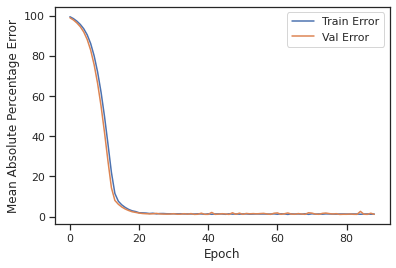

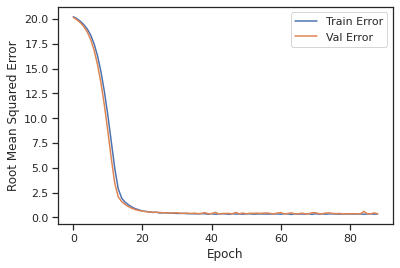

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()


  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Root Mean Squared Error')
  plt.plot(hist['epoch'], hist['root_mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_root_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


In [ ]:
loss, mean_absolute_percentage_error, root_mean_squared_error = model.evaluate(X_test, y_test)

print("Testing set Mean Absolute Percentage Error: {:5.2f}".format(mean_absolute_percentage_error))
print("Testing set Root Mean Squared Error: {:5.2f}".format(root_mean_squared_error))

12/12 [==============================] - 0s 3ms/step - loss: 0.1894 - mean_absolute_percentage_error: 1.3231 - root_mean_squared_error: 0.4352
Testing set Mean Absolute Percentage Error:  1.32
Testing set Root Mean Squared Error:  0.44


Nuestra métrica de la raíz del error cuadrático medio es de 0.44, lo que quiere decir que la red neuronal no tiene un buen performance, ya que el mejor resultado es el que está más cerca a 0 y no a 1. 

## Predicciones

In [ ]:
from sklearn.metrics import r2_score

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Evaluamos el modelo sobre el conjunto de train y de test
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("% de no tener error en la predicción en el conjunto de entrenamiento es de:", round(r2_train, 3)* 100,"%")
print("% de no tener error en la predicción en el conjunto de testeo es de:", round(r2_test, 3)* 100,"%")

% de no tener error en la predicción en el conjunto de entrenamiento es de: 81.5 %
% de no tener error en la predicción en el conjunto de testeo es de: 61.0 %


Nuestra red neuronal predice relativamente bien en el conjunto de entrenamiento (81%) pero no presenta una buena predicción en el conjunto test (61%), es decir, nuestro modelo de red neuronal no generaliza bien frente a conjuntos de datos nuevos. Quizá pueda estar presentando un sobreajuste (a pesar de que hemos configurado una parada temprana), o puede ser que se necesiten mayor cantidad de datos de entrenamiento para mejorar el funcionamiento de nuestra red neuronal. 

# Modelo Random Forest

Se utiliza un modelo de Random Forest para comparar su performance con el de la red neuronal.

Se escoge este modelo porque al ser un modelo de ensemble learning nos va a ayudar a mantener un buen equilibrio entre sesgo y varianza. El objetivo que se está bucando ahora es reducir la varianza sin aumentar el sesgo, si se logra el modelo tendrá una alta capacidad de generalización, lo que no ocurrió con nuestra red neuronal a pesar de hacer diferentes cambios en sus hiperparámetros y te utilizar la parada temprana.

En este utilizaremos un GridSearchCV con validación repetida para encontrar los mejores hiperparámetros. Para este modelo será interesante probar con aquellos hiperparámetros que ayuden a detener el crecimiento de los árboles, por esta razón se optimizarán los siguientes hiperparámetros: 

* n_estimator: Es el número de árboles que va a tener el modelo. Entre más árboles es mejor, pero a partir de cierto punto se equilibra y deja de mejorar, por lo que no tiene sentido tener más árboles de los necesarios pues esto representaría una pérdida de recursos computacionales.Se prueban con 50 y 150 árboles. 

* max_features: Es el número de predictores considerados en cada división, éste garantiza que los árboles utilizados sean diferentes entre sí, lo que evitaría la correlación en caso de que se tengan árboles con una relación alta, lo que impactaría directamente en la varianza haciendo que ésta se reduzca. Lo anterior puede estar ocurriendo en nuestro problema de predicción de precios de inmuebles, si se tiene en cuenta la cantidad de variables que generamos después de haber hecho la binarización con One Hot Encoding. Podría ser que algunas de las variables entre barrios estén de cierta manera muy correlacionadas.  

  Este parámentro lo probaremos con "auto" (utiliza todos los predictores) a su vez, vamos probar con números enteros. 

* max_depth: es la profundidad máxima que pueden alcanzar los árboles. Se probará con "None" y algunos números enteros. 

## Entrenamiento del modelo

In [ ]:
# Se importan las librerías
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Optimización de hiperparámetros

param_grid_rdf = {
    'n_estimators': [50, 150],
    'max_features': ["auto", 3, 7, 13],
    'max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda GridSearchCV con validación cruzada repetida

grid = GridSearchCV( RandomForestRegressor(), 
                    param_grid=param_grid_rdf, 
                    scoring= "r2", 
                    n_jobs= - 1,  
                    cv= RepeatedKFold(n_splits = 5, n_repeats = 3, random_state=123),
                    refit=True, 
                    verbose=3,  
                    return_train_score=True)

grid.fit(X_train, y_train)

Fitting 15 folds for each of 40 candidates, totalling 600 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=123),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10, 20],
                         'max_features': ['auto', 3, 7, 13],
                         'n_estimators': [50, 150]},
             return_train_score=True, scoring='r2', verbose=3)

In [ ]:
# Mejores hiperparámetros por validación cruzada

print("Mejores hiperparámetros encontrados (cv)")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

Mejores hiperparámetros encontrados (cv)
{'max_depth': 20, 'max_features': 13, 'n_estimators': 150} : 0.8931796193969664 r2


## Predicciones

In [ ]:
modelo = grid.best_estimator_

y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)

#Evaluamos el modelo sobre el conjunto de train y de test
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("El porcentaje de no tener error en la predicción en el conjunto de entrenamiento es de:", round(r2_train, 4)* 100,"%")
print("El porcentaje de no tener error en la predicción en el conjunto de test es de:", round(r2_test, 4)* 100,"%")

El porcentaje de no tener error en la predicción en el conjunto de entrenamiento es de: 98.02 %
El porcentaje de no tener error en la predicción en el conjunto de test es de: 91.13 %


Después de hacer las predicciones con los mejores hiperparámetros sobre el conjunto de train se obtuvo un r2 de 98% y en el conjunto de test se obtuvo un r2 de 91.13%. Con lo que podemos concluir que el modelo de Random Forest obtiene mejores resultados que la red neuronal. Una mejoras que se le podrían hacer para que el modelo de Redes Neuronales funcione mejor es obtener más datos para entrenar a la red y aplicar PCA (Principal Component Analysis) para reducir la dimensionalidad del dataset, pues después de hacer el OneHotEncoding se aumentó el número de variables a 128 lo que probablemente esté ocasionando correlaciones entre las variables predictoras y afectando la capacidad de predicción del modelo. Al utilizar PCA podríamos minimizar la varianza del modelo.